In [7]:
%matplotlib inline

import numpy as np
from numpy import linalg as LA
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.colors import LogNorm

In [8]:
class BayesianLinearRegression:
  """
    Linear regression model: y = w[0]+w[1]x
    w ~ N(0,alpha^2*I)
    P(y|x,w,sigma) ~ N(y|x.dot(w),sigma**2)
  """

  def __init__(self, alpha=np.sqrt(10.), w_mu=0, sigma=5, fit_intercept=True):
    """
      alpha: standard deviation of the prior for each of the feature dimensions.
      w_mu:  the mean of the prior
      sigma: variance of the prediction error.
    """
    self.alpha = np.asarray(alpha)
    self.w_mu  = np.asarray(w_mu)
    self.sigma = sigma
    self.fit_intercept = fit_intercept

  def add_intercept(self, X):
    X_new = np.ones((X.shape[0],X.shape[1]+1), dtype=X.dtype)
    X_new[:,1:] = X[:,:]
    return X_new

  def fit_ml(self, X, y):
    """
      Fit a Maximum Likelihood estimate. (not Bayesian)
      X: features, n_samples by n_features nd-array
      y: target values, n_samples array
    """
    if self.fit_intercept:
      X = self.add_intercept(X)
    self.w = LA.inv(X.T.dot(X)).dot(X.T.dot(y))

  def fit_map(self, X, y):
    """
      Fit a MAP estimate
      X: features, n_samples by n_features nd-array
      y: target values, n_samples array
    """
    if self.fit_intercept:
      X = self.add_intercept(X)
    
    #data setup
    f_dim = X.shape[1]
    w_mu = self.w_mu
    sigma = self.sigma
    alpha = self.alpha
    
    #Posterior distribution
    S_0_inv = np.diagflat(1./np.asarray(alpha*alpha))
    S_pos = LA.inv( S_0_inv + 1./(sigma*sigma)*X.T.dot(X)   )
    mu_pos = S_pos.dot( S_0_inv.dot(w_mu) +1./(sigma*sigma)*X.T.dot(y) ) 
    
    self.w = mu_pos
    self.Sigma = S_pos
    
  def predict(self, X):
    if self.fit_intercept:
      X = self.add_intercept(X)
    return X.dot(self.w)

In [9]:
"""
  Run some tests on the Bayesian Linear Regression.
"""

'\n  Run some tests on the Bayesian Linear Regression.\n'

In [10]:
#For quntifying prediction error
def mse(X,y,clf):
    d = y-clf.predict(X)
    return 1/float(len(y)) * d.T.dot(d)

#read some test data
Xtest = np.loadtxt("Xtest.txt")
Xtrain = np.loadtxt("Xtrain.txt")

y_test = np.loadtxt("Ytest.txt")
y_train = np.loadtxt("Ytrain.txt")

n_samples = [2,10,100]

def run_clf(clf):
  for n in n_samples:
      X = Xtrain[:n]
      y = y_train[:n]
      clf.fit_map(X,y)
      error_map = mse(Xtest,y_test,clf)
      clf.fit_ml(X,y)
      error_ml = mse(Xtest,y_test,clf)

      print "samples: %d, ML mse: %f MAP mse: %f" % (n,error_ml, error_map)


# test different initializations of the classifier:


In [5]:
print "vector arguments"
clf =   BayesianLinearRegression(
        alpha=np.array([3.,3.]),
        w_mu=([0.,0.]),
        sigma=5, fit_intercept=False,
        )
run_clf(clf)

vector arguments
samples: 2, ML mse: 170.249002 MAP mse: 167.980245
samples: 10, ML mse: 27.021498 MAP mse: 37.237198
samples: 100, ML mse: 26.476821 MAP mse: 26.811581


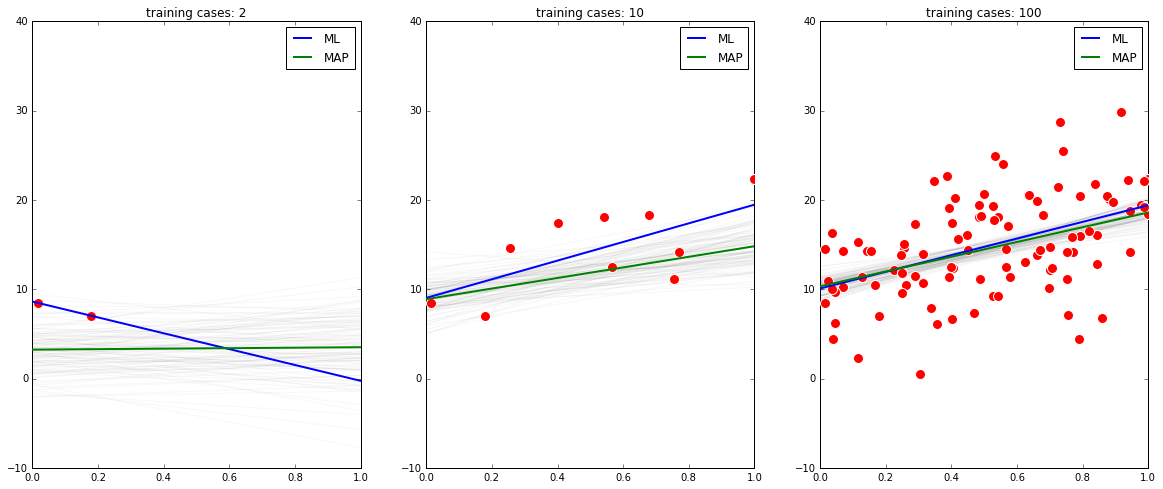

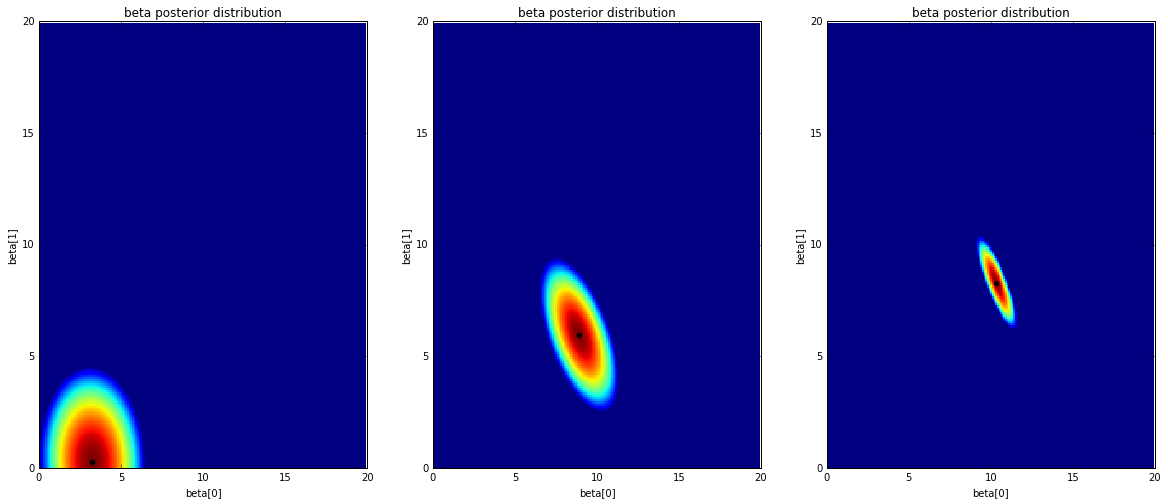

In [6]:
#let's do some interesting plots:


fig = plt.figure(figsize=(20,8))
for i,n in enumerate(n_samples):
    X = Xtrain[:n]
    y = y_train[:n]

    clf.fit_map(X,y)
    beta_map = clf.w
    error_map = mse(Xtest,y_test,clf)
    Sigma = clf.Sigma
#    Sigma_inv = LA.inv(Sigma)

    clf.fit_ml(X,y)
    beta_ml = clf.w
    error_ml = mse(Xtest,y_test,clf)

    ax=plt.subplot(1,3,i+1)
    ax.set_xlim(0,1)
    ax.set_ylim(-10,40)
   #draw from posterior:
    for i in range(0,100):#10000):
      beta = multivariate_normal(beta_map, Sigma)
      ax.plot([0, 1.0], [beta[0], beta[0]+1.0*beta[1]], color='k', linestyle='-', linewidth=1,zorder=1, alpha=0.03)
    ax.plot([0, 1.0], [beta_ml[0], beta_ml[0]+1.0*beta_ml[1]], linestyle='-', linewidth=2, label="ML",zorder=100)
    ax.plot([0, 1.0], [beta_map[0], beta_map[0]+1.0*beta_map[1]], linestyle='-', linewidth=2, label="MAP",zorder=100)

    ax.scatter(X[:,1],y, marker="o", color='r', edgecolor="white", s=100,zorder=10)
 
    plt.legend()
    plt.title("training cases: %d" % n)

fname = "ml_vs_map.png"
fig.savefig(fname)

#some plots of the beta posterior distribution:

fig = plt.figure(figsize=(20,8))
plt.clf()
for i,n in enumerate(n_samples):
    X = Xtrain[:n]
    y = y_train[:n]

    clf.fit_map(X,y)
    beta_map = clf.w
    error_map = mse(Xtest,y_test,clf)
    Sigma = clf.Sigma
    Sigma_inv = LA.inv(Sigma)

    clf.fit_ml(X,y)
    beta_ml = clf.w
    error_ml = mse(Xtest,y_test,clf)

    mu = beta_map
    ax=plt.subplot(1,3,i+1)
    delta = 0.1
    x = np.arange(0., 20.0, delta)
    y = np.arange(0., 20.0, delta)
    z = np.zeros((len(x),len(y)))
    xx,yy = np.meshgrid(x, y)
    q = np.log(np.power(LA.det(2 * np.pi * Sigma),-0.5))
    for i in range(len(x)):
      for j in range(len(y)):
        beta = np.array([xx[i,j], yy[i,j]])
        d = beta - mu
        r = 1
        # d is a row vector -> therefore the transpose is the other way around
        r += -0.5 * d.dot(Sigma_inv).dot(d[:,np.newaxis])
        z[i,j] = r
    #cs = plt.contour(xx, yy, z, 20, colors='k')
    #plt.clabel(cs, inline=1, fontsize=10)
    plt.pcolor(xx,yy,z,vmin=0.,vmax=1)
    plt.scatter(mu[0],mu[1],c='k')
    plt.xlabel("beta[0]")
    plt.ylabel("beta[1]")
    plt.xlim(0,20)
    plt.ylim(0,20)

    plt.title("beta posterior distribution")

fname = "posterior.png"
fig.savefig(fname)
plt.show()






